In [1]:
import os as os
import sys as sys
import subprocess as sp
import glob as glob
import math as math
import numpy as np
import scipy as sc
import subprocess as subprocess
import matplotlib as mpl
import matplotlib.pyplot as plt

from numpy import genfromtxt
from scipy import stats
from functools import reduce

from aesthetics import *

import pytraj as pt

In [2]:
%matplotlib inline

# Run `cpptraj` directly

In [3]:
cpptraj_input = '''
parm sample-data/pure-opc/full.topo
trajin sample-data/pure-opc/traj.001
unwrap
diffusion average 10
'''

In [4]:
file = open('cpptraj.in', 'w')
file.write(cpptraj_input)
file.close()

In [5]:
import subprocess as sp

In [6]:
sp.check_output(["/home/dslochower/amber14gnu/bin/cpptraj -i cpptraj.in"], shell=True)

b'\nCPPTRAJ: Trajectory Analysis. V15.00\n    ___  ___  ___  ___\n     | \\/ | \\/ | \\/ | \n    _|_/\\_|_/\\_|_/\\_|_\n\n| Date/time: 08/02/16  15:21:29\n| Available memory: 4946.67 MB\n\nINPUT: Reading Input from file cpptraj.in\n  [parm sample-data/pure-opc/full.topo]\n\tReading \'sample-data/pure-opc/full.topo\' as Amber Topology\n  [trajin sample-data/pure-opc/traj.001]\n\tReading \'sample-data/pure-opc/traj.001\' as Amber NetCDF\n  [unwrap]\n    UNWRAP: By atom using mask \'*\'\n\tReference is first frame.\n  [diffusion average 10]\n    DIFFUSION:\n\tAtom Mask is [*]\n\tOnly the average results will be printed to:\n\t  diffusion_x.xmgr: Mean square displacement(s) in the X direction (in \xc3\x85^2).\n\t  diffusion_y.xmgr: Mean square displacement(s) in the Y direction (in \xc3\x85^2).\n\t  diffusion_z.xmgr: Mean square displacement(s) in the Z direction (in \xc3\x85^2).\n\t  diffusion_r.xmgr: Overall mean square displacement(s) (in \xc3\x85^2).\n\t  diffusion_a.xmgr: Total distan

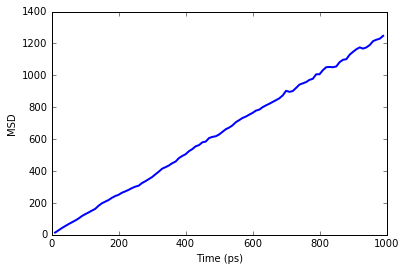

In [7]:
data = np.genfromtxt('diffusion_r.xmgr')
times = data[:, 0]
msd  = data[:, 1]
plt.figure()
plt.plot(times, msd, c='b', lw=2)
plt.xlabel('Time (ps)')
plt.ylabel('MSD')
plt.show()

# Read data from `cpptraj` directly.

In [8]:
data = np.genfromtxt('sample-data/pure-opc/diffusion_r.xmgr')
times = data[:, 0]
msd  = data[:, 1]

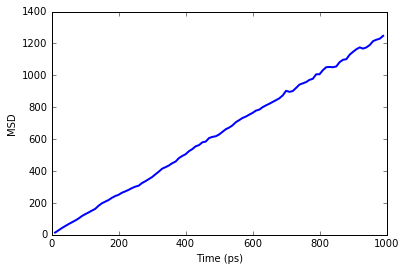

In [9]:
plt.figure()
plt.plot(times, msd, c='b', lw=2)
plt.xlabel('Time (ps)')
plt.ylabel('MSD')
plt.show()

The output of `cpptraj` says:
>	The time between frames in ps is 10.000.
>	To calculate diffusion constants from a mean squared displacement plot
>	(i.e. {_x|_y|_z|_r}.xmgr), calculate the slope of the line and multiply
>	by 10.0/6.0; this will give units of 1x10^-5 cm^2/s

In [10]:
slope = (msd[-1] - msd[0]) / (times[-1] - times[0])
print('The slope of the MSD plot is {} A**2 per ps'.format(slope))
print(r'This equals {} $\times 10^{{-5}}$ cm**2 per second'.format(10.0/6.0 * slope))

The slope of the MSD plot is 1.259354081632653 A**2 per ps
This equals 2.098923469387755 $\times 10^{-5}$ cm**2 per second


# Run `cpptraj` through python

In [23]:
text = """
unwrap
diffusion average 10
"""

In [24]:
traj = pt.iterload('sample-data/pure-opc/traj.001', 'sample-data/pure-opc/full.topo')

In [25]:
state = pt.load_cpptraj_state(text, traj)
state.run()

CpptrajState, include:
<datasetlist: 11 datasets>

In [26]:
state.data.keys()

['full.topo',
 'average[X]',
 'average[Y]',
 'average[Z]',
 'average[R]',
 'average[A]',
 'average[D]',
 'average[Label]',
 'average[Slope]',
 'average[Intercept]',
 'average[Corr]']

In [27]:
state.data['average[Label]']

<pytraj.datasets.DatasetString: size=4, key=average[Label]> 
values: 
['average_AvgDr' 'average_AvgDx' 'average_AvgDy' 'average_AvgDz']

In [28]:
state.data['average[Slope]']

<pytraj.datasets.DatasetDouble: size=4, key=average[Slope]> 
values: 
[ 12.65209011   4.24151462   3.92319491   4.48738058]

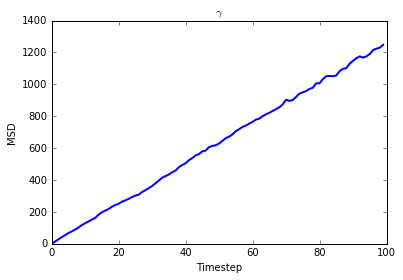

In [29]:
plt.figure()
plt.plot(range(len(state.data['average[R]'])), state.data['average[R]'], c='b', lw=2)
plt.xlabel('Timestep')
plt.ylabel('MSD')
plt.title('$\gamma$')
plt.show()

# Run `pytraj` directly

In [36]:
traj = pt.iterload('sample-data/pure-opc/traj.001', 'sample-data/pure-opc/full.topo')

In [37]:
diffusion = pt.diffusion(traj, tstep=10, dtype='dict')

In [92]:
diffusion['Slope']

array([ 1.26312494,  0.42324363,  0.39170921,  0.4481721 ])

In [326]:
diffusion

<function __main__.diffusion>

In [328]:
traj = pt.iterload('sample-data/dave-opc-test/traj.001', 'sample-data/dave-opc-test/full.topo')

In [329]:
pt_diffusion = pt.diffusion(traj, tstep=2, dtype='dict')

In [331]:
pt_diffusion['Slope'] * 10.0/6.0

array([ 1.96563044,  0.65052426,  0.65908333,  0.65602285])

# Let's try `mdanalysis`

In [68]:
import MDAnalysis

/home/dslochower/anaconda3/lib/python3.5/site-packages/MDAnalysis/__init__.py:190: UserWarning: #####
MDAnalysis on python 3 is highly experimental!
It is mostly non functional and dramatically untested.
Use at your own risks!!!

  ''')


In [3]:
def diffusion(topology, trajectory, ps_per_frame, fit=True, plot=False):
    cpptraj_input = '''
    parm {}
    trajin {}
    unwrap
    diffusion average {}
    '''.format(topology, trajectory, ps_per_frame)
    file = open('diffusion.in', 'w')
    file.write(cpptraj_input)
    file.close()
    # sp.check_output(['echo $AMBERHOME'], env=dict(os.environ), shell=True)
    sp.check_output(["$AMBERHOME/bin/cpptraj -i diffusion.in"], env=dict(os.environ), shell=True)
    # sp.check_output(['mv', 'cpptraj.log', 'diffusion.log'])
    # Make a cleanup script. Check if this has run correctly...
    data = np.genfromtxt('diffusion_r.xmgr')
    times = data[:, 0]
    msd  = data[:, 1]
    if not fit:
        slope = (msd[-1] - msd[0]) / (times[-1] - times[0])
    else:
        middle_eighty = np.arange(int(0.1*len(times)), int(0.9*len(times)))
        slope, intercept, r_value, p_value, std_err = sc.stats.linregress(times[middle_eighty], msd[middle_eighty])
    D = 10.0/6.0 * slope
    print(r'The diffusion coefficient is {} $\times 10^{{-5}}$ cm$^2$/s.'.format(D))
    
    if plot:
        fig, ax = plt.subplots()
        ax.plot(times, msd, c='b', lw=2)
        ax.plot(times, slope * times + intercept, c='r', ls='--', lw=2)
        ax.set_title(r'Slope = {0:0.2f} $\mathrm{{\AA}}^2$/ps, D = {1:0.2f} $\times 10^{{-5}}$ cm$^2$/s'.format(slope, D))
        pretty_label(ax)
        plt.show()
    return D

In [293]:
def difference_from_experiment(computed, experimental):
    assert len(computed) == len(experimental)
    for property in computed:
        computed[property] - experimental[property]

In [59]:
diffusion('sample-data/pure-opc/full.topo', 'sample-data/pure-opc/traj.001', 10)

The diffusion coefficient is 2.1087335209235207 $\times 10^{-5}$ cm$^2$/s.


In [49]:
diffusion('sample-data/pure-opc-2/full.topo', 'sample-data/pure-opc-2/traj.001', 10)

The diffusion coefficient is 2.150264766027623 $\times 10^{-5}$ cm$^2$/s.


In [50]:
diffusion('sample-data/pure-opc-3/full.topo', 'sample-data/pure-opc-3/traj.001', 10)

The diffusion coefficient is 2.2530296021438883 $\times 10^{-5}$ cm$^2$/s.


In [51]:
diffusion('sample-data/pure-opc-4/full.topo', 'sample-data/pure-opc-4/traj.001', 10)

The diffusion coefficient is 2.063848111729541 $\times 10^{-5}$ cm$^2$/s.


In [53]:
diffusion('sample-data/pure-opc-5/full.topo', 'sample-data/pure-opc-5/traj.001', 10)

The diffusion coefficient is 2.0791517212945783 $\times 10^{-5}$ cm$^2$/s.


The diffusion coefficient is 2.2670198292701986 $\times 10^{-5}$ cm$^2$/s.


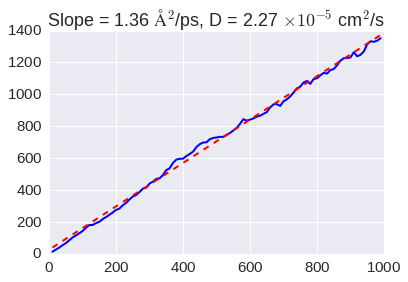

In [298]:
diffusion('sample-data/pure-opc-6/full.topo', 'sample-data/pure-opc-6/traj.001', 10, plot=True)

### Samples are taken every 2 ps.

The diffusion coefficient is 1.9797317992777583 $\times 10^{-5}$ cm$^2$/s.


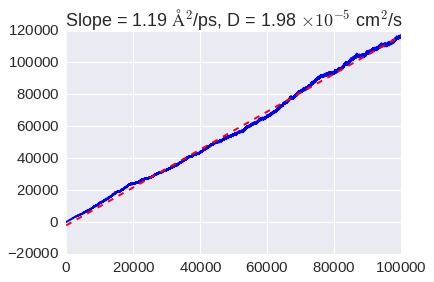

In [308]:
diffusion('sample-data/dave-opc-test/full.topo', 'sample-data/dave-opc-test/traj.001', 2, plot=True)

In [309]:
def blocking_analysis(blocks, trajectory):
    mean_for_each_block_size = np.empty((len(blocks)))
    sem_for_each_block_size = np.empty((len(blocks)))
    sem_error_for_each_block_size = np.empty((len(blocks)))
    for block_size in blocks:
        number_measurements = math.floor(len(trajectory) / block_size)
        # Loop over all blocks of the same size...
        mean_for_each_block = np.empty((number_measurements))
        for block in range(number_measurements):
            mean_for_each_block[block] = analysis(trajectory, block * block_size, 
                                                          block * block_size + block_size, 
                                                          block_size)
        sem_for_each_block_size[blocks.index(block_size)] = stats.sem(mean_for_each_block)
        sem_error_for_each_block_size[blocks.index(block_size)] = sem_for_each_block_size[blocks.index(block_size)] / np.sqrt(2 * (number_measurements - 1))
        mean_for_each_block_size[blocks.index(block_size)] = np.mean(mean_for_each_block)
    return sem_for_each_block_size, sem_error_for_each_block_size, mean_for_each_block_size

In [310]:
def analysis(trajectory, tj_start, tj_stop, block_length):
    slope = (trajectory[tj_stop] - trajectory[tj_start]) / (2 * block_length) # Factor of 2 is for 2 ps
    return slope

In [311]:
    cpptraj_input = '''
    parm sample-data/dave-opc-test/full.topo
    trajin sample-data/dave-opc-test/traj.001
    unwrap
    diffusion average 2
    '''
    file = open('diffusion.in', 'w')
    file.write(cpptraj_input)
    file.close()
    # sp.check_output(['echo $AMBERHOME'], env=dict(os.environ), shell=True)
    sp.check_output(["$AMBERHOME/bin/cpptraj -i diffusion.in"], env=dict(os.environ), shell=True)
    # sp.check_output(['mv', 'cpptraj.log', 'diffusion.log'])
    # Make a cleanup script. Check if this has run correctly...
    data = np.genfromtxt('diffusion_r.xmgr')
    times = data[:, 0]
    msd  = data[:, 1]


In [323]:
blocks = list(np.arange(2, 100000, 200))
blocks = factorize(len(msd))
blocks

[1, 49999]

In [325]:
len(msd)

49999

In [318]:
sem, sem_error, means = blocking_analysis(blocks, msd)

/home/dslochower/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/home/dslochower/anaconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [319]:
sem

array([ 0.29591887,  0.05938476,  0.05453098, ...,         nan,
               nan,         nan])

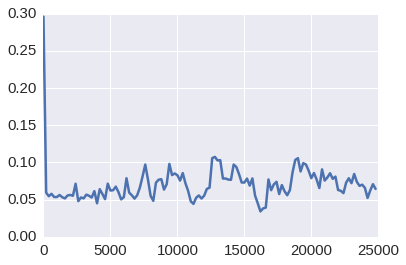

In [320]:
plt.figure()
plt.plot(blocks, sem)
plt.show()

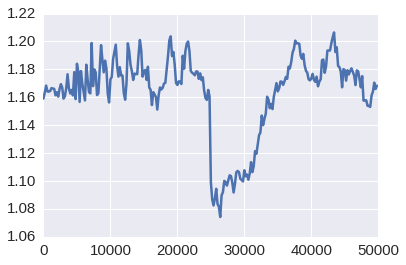

In [321]:
plt.figure()
plt.plot(blocks, means)
plt.show()

In [290]:
(msd[-1] - msd[0]) / ((times[-1] - times[0]))

1.1321586757990865

In [284]:
msd[-1] - msd[0]

8925.9389999999985

In [39]:
dir = 'sample-data/dave-opc-test4'

In [40]:
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))


In [41]:
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 2.160169117647059 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.1011985294117648 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.1039901960784313 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.161389705882353 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.591473039215686 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.310156862745098 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.3813651960784314 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.1809779411764705 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.0383897058823526 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.3048774509803924 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.2751911764705883 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.330808823529412 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.9814460784313725 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2

In [42]:
Ds

array([ 2.16016912,  2.10119853,  2.1039902 , ...,  2.42900735,
        2.41738971,  2.30391176])

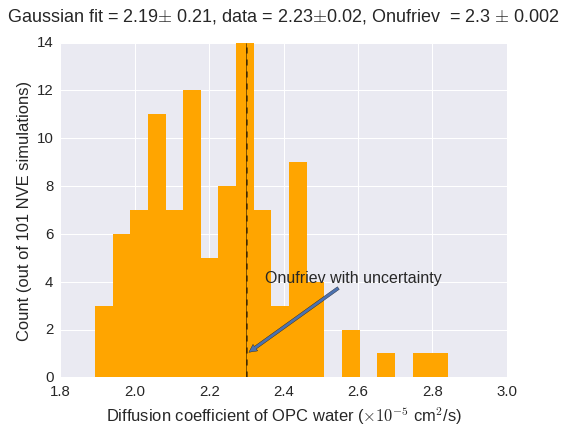

In [43]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
plt.axvline(x = 2.3 - 0.002, c='k', ls='--', lw=0.5)
plt.axvline(x = 2.3 + 0.002, c='k', ls='--', lw=0.5)
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 4), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [44]:
dir = 'sample-data/dave-opc-test3'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 2.160169117647059 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.1797916666666666 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.0341960784313726 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.1401985294117647 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.1700294117647057 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 0.9753357843137256 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.052267156862745 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.0530563725490196 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.230416666666667 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.119924019607843 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.2072254901960786 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.2090122549019608 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.2967818627450984 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 

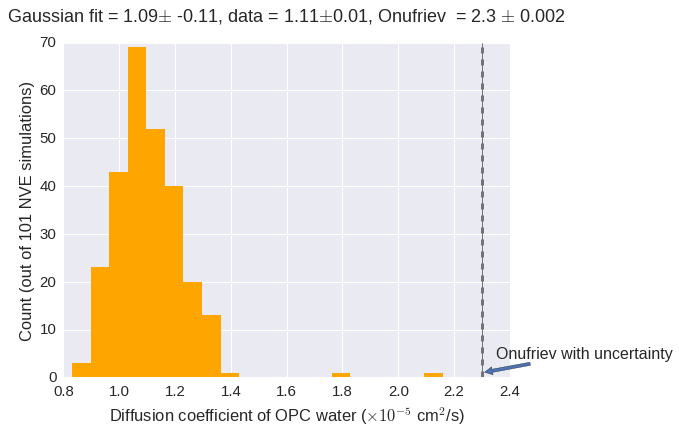

In [45]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit
coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
plt.axvline(x = 2.3 - 0.002, c='k', ls='--', lw=0.5)
plt.axvline(x = 2.3 + 0.002, c='k', ls='--', lw=0.5)
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 4), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [47]:
# Separate NVE trajectories
dir = 'sample-data/dave-opc-test5'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 2.3142906157665872 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.096512502363285 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.0649192682137003 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.20322767859563 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.8758553224497225 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.2415310342867727 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.111542137448652 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.183442855652899 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.160829764441038 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.286675123222849 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.630489515608618 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.19064971415971 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.0822966314400495 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.9608

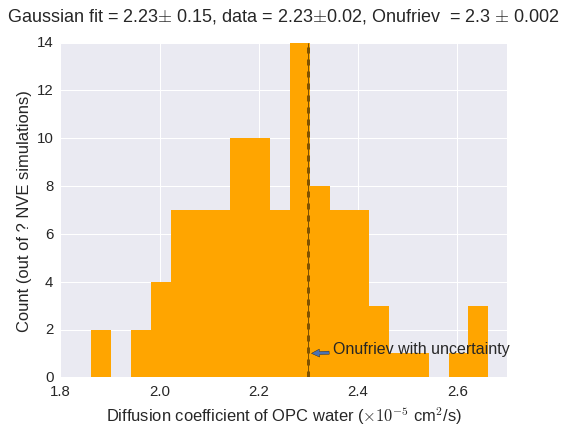

In [48]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
plt.axvline(x = 2.3 - 0.002, c='k', ls='--', lw=0.5)
plt.axvline(x = 2.3 + 0.002, c='k', ls='--', lw=0.5)
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of ? NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 1), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [62]:
# test 6, iwrap off 20/80 NPT/NVE
dir = 'sample-data/dave-opc-test6'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 2.160169117647059 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.9976813725490195 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.3620931372549023 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.2051887254901965 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 1.9926568627450985 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.3763284313725492 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.1888333333333336 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.0832720588235296 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.281482843137255 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.5524975490196073 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.103781862745098 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.27430637254902 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.9373946078431374 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2

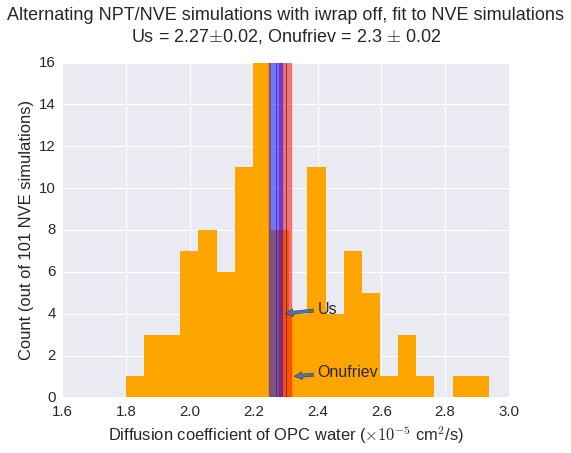

In [90]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
# plt.axvline(x = 2.3 - 0.02, c='k', ls='--', lw=0.5)
# plt.axvline(x = 2.3 + 0.02, c='k', ls='--', lw=0.5)
plt.axvspan(2.3 - 0.02, 2.3 + 0.02, color='r', alpha=0.5)

plt.axvline(x = np.mean(Ds), c='b', ls='-', lw=0.5)
#plt.axvline(x = np.mean(Ds) - sc.stats.sem(Ds), c='b', ls='--', lw=0.5)
#plt.axvline(x = np.mean(Ds) + sc.stats.sem(Ds), c='b', ls='--', lw=0.5)
plt.axvspan(np.mean(Ds) - sc.stats.sem(Ds), np.mean(Ds) + sc.stats.sem(Ds), color='b', alpha=0.5)

# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev', size=16, xy=(2.3 + 0.02, 1), xytext=(2.4, 1), arrowprops = dict(arrowstyle='simple'))
ax.annotate('Us', size=16, xy=(np.mean(Ds) + sc.stats.sem(Ds), 4), xytext=(2.4, 4), arrowprops = dict(arrowstyle='simple'))
ax.set_title('Alternating NPT/NVE simulations with iwrap off, fit to NVE simulations\nUs = {2:0.2f}$\pm${3:0.2f}, Onufriev = 2.3 $\pm$ 0.02'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [52]:
# test 7, iwrap off, com removal off, 20/80 NPT/NVE
dir = 'sample-data/dave-opc-test7'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 3.613536764705882 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.6747867647058827 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.959536764705882 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 4.741588235294118 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.5871470588235295 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.292468137254902 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.5137647058823527 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.7077573529411763 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 4.505708333333334 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.765625 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.1187867647058827 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 4.272156862745098 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.687835784313726 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.10325245098

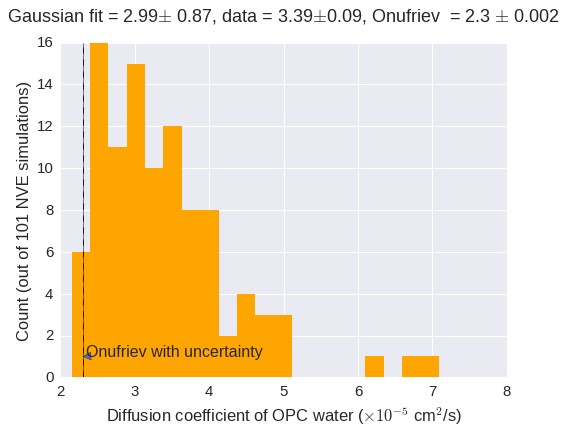

In [53]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
plt.axvline(x = 2.3 - 0.002, c='k', ls='--', lw=0.5)
plt.axvline(x = 2.3 + 0.002, c='k', ls='--', lw=0.5)
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 1), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [55]:
# test 8, iwrap off, com removal off... 
dir = 'sample-data/dave-opc-test8'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-opc-test/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 3.613536764705882 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.636078431372549 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.4837254901960786 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.4939632352941175 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.7174632352941175 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.2163480392156862 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 2.751884803921569 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.209573529411765 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 6.600700980392157 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 3.0371446078431372 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 4.845865196078431 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 8.508821078431373 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 4.052661764705882 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 8.73

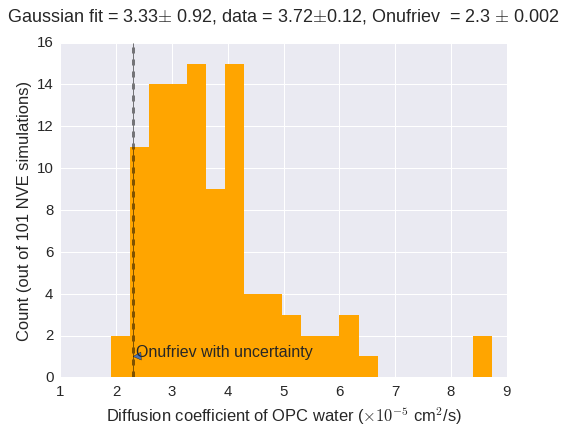

In [56]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2

coeff, var_matrix = curve_fit(gauss, center, hist, p0=p0)
fit_points = np.linspace(1.8, 3.0, 50)
hist_fit = gauss(fit_points, *coeff)


plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
plt.axvline(x = 2.3, c='k', ls='-', lw=0.5)
plt.axvline(x = 2.3 - 0.02, c='k', ls='--', lw=0.5)
plt.axvline(x = 2.3 + 0.02, c='k', ls='--', lw=0.5)
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 1), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()

In [59]:
# test 8, iwrap off, com removal off... 
dir = 'sample-data/dave-tp3-test2'
trajectories = sorted(glob.glob(dir + '/traj.nve.*'))
Ds = np.empty((len(trajectories)))
for trajectory in trajectories:
    # diffusion(dir + '/full.topo', trajectory, 1 )
    # print('Trajectory {} out of {}'.format(trajectories.index(trajectory), len(trajectories)))
    Ds[trajectories.index(trajectory)] = diffusion('sample-data/dave-tp3-test2/full.topo', trajectory, 1, plot=False)

The diffusion coefficient is 5.312026960784313 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.624740196078432 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.783264705882353 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.461960784313725 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.987659313725491 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.583529411764706 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.310843137254903 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.296872549019608 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.876556372549019 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.339102941176471 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.143840686274509 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.225938725490197 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.712188725490196 $\times 10^{-5}$ cm$^2$/s.
The diffusion coefficient is 5.4458063

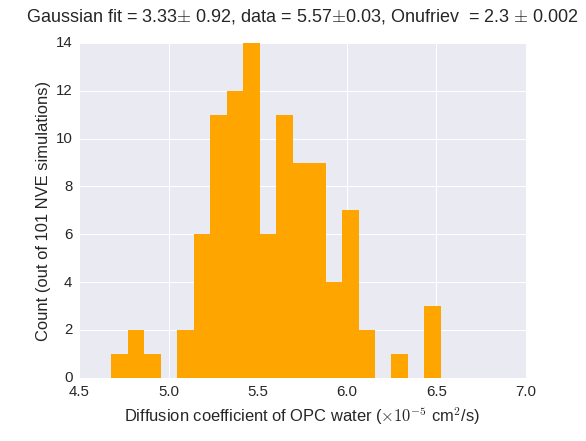

In [61]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 0., 1.]

from scipy.optimize import curve_fit

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
hist, bins = np.histogram(Ds, bins=20)
width = 1.0 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2



plt.bar(center, hist, align='center', width=width, edgecolor=None, lw=0, color='orange')
# plt.plot(fit_points, hist_fit, c='r')
plt.xlabel(r'Diffusion coefficient of OPC water ($\times 10^{-5}$ cm$^2$/s)')
plt.ylabel('Count (out of 101 NVE simulations)')
ax.annotate('Onufriev with uncertainty', size=16, xy=(2.3 + 0.002, 1), xytext=(2.35, 1), arrowprops = dict(arrowstyle='simple'))
ax.set_title(r'Gaussian fit = {0:0.2f}$\pm$ {1:0.2f}, data = {2:0.2f}$\pm${3:0.2f}, Onufriev  = 2.3 $\pm$ 0.002'.
          format(coeff[1], coeff[2], np.mean(Ds), sc.stats.sem(Ds)), y=1.05)
plt.show()